# Visualizing Raw 2-Photon Images
Some of The Allen Institute's 2-Photon NWB Files contain the *raw movie* for the session. That is, they contain the 2P images over time. Because these movies are very large, they aren't packaged with all of our 2P NWB Files. From the raw 2P images, the The Allen Institute uses the **[Suite2P](https://github.com/MouseLand/suite2p)** segmentation algorithm to identify *regions of interest* (ROIs). For more information on Suite2P see [Identifying Regions of Interest with Segmentation](../first-order/suite2p.ipynb). Each ROI is a putative neuron within the image. These ROIs are examined and their fluorescence is stored to measure neuronal activity over time. This notebook extracts the ROI information from the NWB Files and creates an interactive display of the 2P movie.

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import numpy as np

from matplotlib import pyplot as plt
from mpl_interactions import hyperslicer

### Streaming Ophys File
Streaming a file from DANDI requires information about the file of interest. The file used below is from a dataset from OpenScope's **Credit Assignment** dataset. Set `dandiset_id` to be the ID of the dandiset you want, and set `dandi_filepath` to be the path of the file within the dandiset. The filepath can be found if you press on the `i` icon of a file and copy the `path` field that shows up in the resulting JSON. If you are accessing embargoed data, you will need to set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000037"
dandi_filepath = "sub-411771/sub-411771_ses-761269197_obj-raw_behavior+image+ophys.nwb"
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_stream_open(dandiset_id, dandi_filepath, dandi_api_key=dandi_api_key)
nwb = io.read()

### Extracting 2P Raw Data
Below, the 2P `movie` is taken from the `acquisition` section of the file. This is the 3D data where the dimensions are *time* x *pixels (width)* x *pixels (height)*. Additionally, the `roi_masks` of all the ROIs are taken from the file's `processing` section. This is a black and white image showing where in the frame the ROIs are. `flr_timestamps` are also grabbed, which are used to tell us at what time each frame of the movie happened.

In [5]:
movie = nwb.acquisition["motion_corrected_stack"].data
# some files come with the composite roi masks already. if so, use this
# roi_masks = np.array(nwb.processing["ophys"]["images"]["segmentation_mask_image"])

flr = nwb.processing["ophys"]["DfOverF"]
flr_timestamps = np.array(flr.roi_response_series["RoiResponseSeries"].timestamps)

roi_table = nwb.processing["ophys"]["DfOverF"].roi_response_series["RoiResponseSeries"].rois
roi_masks = np.logical_or.reduce([row["image_mask"].item() for row in roi_table])

print(movie.shape)
print(flr_timestamps.shape)
print(roi_masks.shape)

(126729, 512, 512)
(126729,)
(512, 512)


### Selecting a Period
Because the image data are so large, it is advised the you select a subsection of the data to view. Set `start_time` to the time, in seconds, of the first image frame you want to be displayed, and `end_time` to be the last. These get translated into the indices of the movie. Below are printed the first and last timestamps from the 2P data to inform this choice. The larger the period, the longer it will take to display. It is recommended the period length is less than 60 seconds.

In [6]:
# start_time = flr_timestamps[0]
start_time = 540
# end_time = flr_timestamps[-1]
end_time = 600

In [7]:
# translate times into indices using timestamps

start_idx, end_idx = None, None
for i, ts in enumerate(flr_timestamps):
    if not start_idx and ts >= start_time:
        start_idx = i
    if start_idx and ts >= end_time:
        end_idx = i
        break

if start_idx == None or end_idx == None:
    raise ValueError("Period bounds not found within 2P data")
    
print(start_idx)
print(end_idx)

15958
17762


### Viewing ROIs and 2P Movie
Below `imshow` is used to display the regions of interest as an image. The ROIs get overlaid onto the movie data with simple numpy addition. Finally, using **mpl_interactions's** `hyperslicer` method, the movie can be shown interactively.

#### Regions of Interest Mask

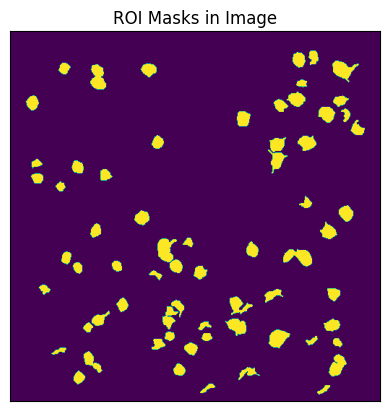

In [8]:
%matplotlib inline
fig, ax = plt.subplots()
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.title("ROI Masks in Image")
plt.imshow(roi_masks)

#### 2P Movie with ROI Mask

In [9]:
### overlaying ROIs onto 2P movie

movie_subset = np.array(movie[start_idx:end_idx])
roi_masks_3d = np.reshape(roi_masks, (1,) + roi_masks.shape)
m = movie_subset.mean()
# mutltiply mask values for visibility
roi_masks_3d = np.multiply(roi_masks_3d, m*10)
movie_masked = np.add(movie_subset, roi_masks_3d)

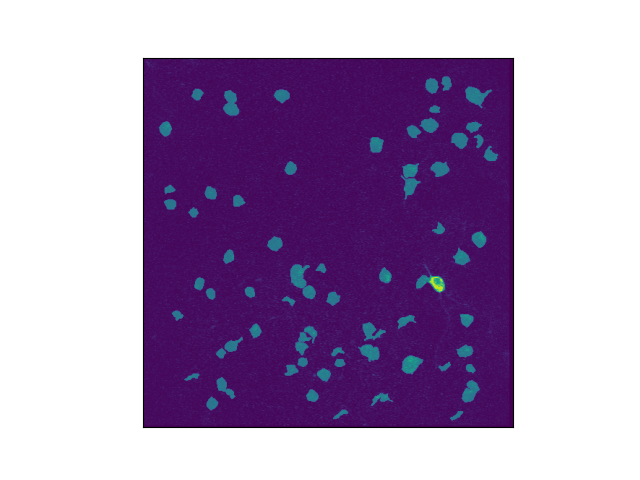

In [10]:
%matplotlib ipympl
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# select this to view with/without ROI masks
view = hyperslicer(movie_masked, play_buttons=True)
# view = hyperslicer(movie_subset, play_buttons=True)